## Set up

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import torch
import itertools
import logging

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, TorchNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.metrics.distributions import NegativeBinomialDistributionLoss

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.utilities.model_summary import summarize

from datetime import datetime, timedelta
from tqdm import tqdm

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# Set logging level to ERROR (suppresses startup info)
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

np.random.seed(42)

In [2]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [3]:
features_df = pd.read_json('../../dataset/combined_retails_and_exog_data/combined_data.json')
features_df

,Date,TimeIdx,Description,AvgPricePerUnitPounds,DayBeforeUnitsSold,DayBeforeLog1pUnitsSold,WeekBeforeUnitsSold,WeekBeforeLog1pUnitsSold,Rolling3DayMeanUnitsSold,Rolling3DayMeanLog1pUnitsSold,...,IsWeekend,DayOfWeek,DayOfMonth,Month,Quarter,CCI,CPI,InterestRate,Unemployment,IsHoliday
0,2009-12-01,1,12 pencils small tube red spotty,0.66,0,0.000000,0,0.000000,0.000000,0.000000,...,False,Tuesday,1,December,Q4,101.64,90.7,0.4517,7.7,False
1,2009-12-02,2,12 pencils small tube red spotty,0.71,45,3.828641,0,0.000000,0.000000,0.000000,...,False,Wednesday,2,December,Q4,101.64,90.7,0.4532,7.7,False
2,2009-12-03,3,12 pencils small tube red spotty,0.69,87,4.477337,0,0.000000,0.000000,0.000000,...,False,Thursday,3,December,Q4,101.64,90.7,0.4522,7.7,False
3,2009-12-04,4,12 pencils small tube red spotty,0.66,34,3.555348,0,0.000000,55.333333,4.031286,...,False,Friday,4,December,Q4,101.64,90.7,0.4502,7.7,False
4,2009-12-05,5,12 pencils small tube red spotty,0.65,84,4.442651,0,0.000000,68.333333,4.238926,...,True,Saturday,5,December,Q4,101.64,90.7,0.4502,7.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,2011-12-05,735,wood black board ant white finish,7.70,5,1.791759,2,1.098612,9.666667,2.367124,...,False,Monday,5,December,Q4,98.18,95.2,0.5273,8.3,False
104934,2011-12-06,736,wood black board ant white finish,7.95,23,3.178054,8,2.197225,9.333333,2.335375,...,False,Tuesday,6,December,Q4,98.18,95.2,0.5272,8.3,False
104935,2011-12-07,737,wood black board ant white finish,6.92,4,1.609438,29,3.401197,10.666667,2.456736,...,False,Wednesday,7,December,Q4,98.18,95.2,0.5264,8.3,False
104936,2011-12-08,738,wood black board ant white finish,5.05,70,4.262680,36,3.610918,32.333333,3.506558,...,False,Thursday,8,December,Q4,98.18,95.2,0.5392,8.3,False


In [4]:
# Make sure we have no NaNs
assert not features_df.isna().any().any()

## Prepare the dataset

In [5]:
tft_df = features_df[[
    'Date',
    'Description',
    'UnitsSold',  # target
    'AvgPricePerUnitPounds',
    'CCI',
    'CPI',
    'InterestRate',
    'Unemployment',
    'DayBeforeUnitsSold',
    'WeekBeforeUnitsSold',
    'Rolling3DayMeanUnitsSold',
    'Rolling7DayMeanUnitsSold',
    'IsWeekend',
    'IsHoliday',
    'DayOfWeek',
    'Month',
    'Quarter',
]].copy()

# Convert calendar categoricals to integer codes
categorical_cols = ['DayOfWeek', 'Month', 'Quarter']
for col in categorical_cols:
    tft_df[col] = pd.Categorical(tft_df[col]).codes  # or .astype("category").cat.codes

# Ensure boolean flags are 0/1 integers
bool_cols = ['IsWeekend', 'IsHoliday']
for col in bool_cols:
    tft_df[col] = tft_df[col].astype(int)

# Define lag and calendar features
lag_features = [
    'DayBeforeUnitsSold',
    'WeekBeforeUnitsSold',
    'Rolling3DayMeanUnitsSold',
    'Rolling7DayMeanUnitsSold',
]
calendar_features = ['IsWeekend', 'IsHoliday']

# Add interaction terms
for lag, cal in itertools.product(lag_features, calendar_features):
    interaction_name = f"{lag}_x_{cal}"
    tft_df[interaction_name] = tft_df[lag] * tft_df[cal]

# Add time index per product
tft_df.insert(
    1,
    'TimeIdx',
    tft_df
    .sort_values(['Description', 'Date'])
    .groupby('Description')
    .cumcount() + 1
)

tft_df['IsWeekend'] = tft_df['IsWeekend'].astype('str')
tft_df['IsHoliday'] = tft_df['IsHoliday'].astype('str')
tft_df['DayOfWeek'] = tft_df['DayOfWeek'].astype('str')
tft_df['Month'] = tft_df['Month'].astype('str')
tft_df['Quarter'] = tft_df['Quarter'].astype('str')

tft_df["UnitsSold"] = tft_df["UnitsSold"].astype("float")

print(tft_df.columns)
tft_df

Index(['Date', 'TimeIdx', 'Description', 'UnitsSold', 'AvgPricePerUnitPounds',
       'CCI', 'CPI', 'InterestRate', 'Unemployment', 'DayBeforeUnitsSold',
       'WeekBeforeUnitsSold', 'Rolling3DayMeanUnitsSold',
       'Rolling7DayMeanUnitsSold', 'IsWeekend', 'IsHoliday', 'DayOfWeek',
       'Month', 'Quarter', 'DayBeforeUnitsSold_x_IsWeekend',
       'DayBeforeUnitsSold_x_IsHoliday', 'WeekBeforeUnitsSold_x_IsWeekend',
       'WeekBeforeUnitsSold_x_IsHoliday',
       'Rolling3DayMeanUnitsSold_x_IsWeekend',
       'Rolling3DayMeanUnitsSold_x_IsHoliday',
       'Rolling7DayMeanUnitsSold_x_IsWeekend',
       'Rolling7DayMeanUnitsSold_x_IsHoliday'],
      dtype='object')


,Date,TimeIdx,Description,UnitsSold,AvgPricePerUnitPounds,CCI,CPI,InterestRate,Unemployment,DayBeforeUnitsSold,...,Month,Quarter,DayBeforeUnitsSold_x_IsWeekend,DayBeforeUnitsSold_x_IsHoliday,WeekBeforeUnitsSold_x_IsWeekend,WeekBeforeUnitsSold_x_IsHoliday,Rolling3DayMeanUnitsSold_x_IsWeekend,Rolling3DayMeanUnitsSold_x_IsHoliday,Rolling7DayMeanUnitsSold_x_IsWeekend,Rolling7DayMeanUnitsSold_x_IsHoliday
0,2009-12-01,1,12 pencils small tube red spotty,45.0,0.66,101.64,90.7,0.4517,7.7,0,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
1,2009-12-02,2,12 pencils small tube red spotty,87.0,0.71,101.64,90.7,0.4532,7.7,45,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
2,2009-12-03,3,12 pencils small tube red spotty,34.0,0.69,101.64,90.7,0.4522,7.7,87,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
3,2009-12-04,4,12 pencils small tube red spotty,84.0,0.66,101.64,90.7,0.4502,7.7,34,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
4,2009-12-05,5,12 pencils small tube red spotty,0.0,0.65,101.64,90.7,0.4502,7.7,84,...,2,3,84,0,0,0,68.333333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,2011-12-05,735,wood black board ant white finish,23.0,7.70,98.18,95.2,0.5273,8.3,5,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
104934,2011-12-06,736,wood black board ant white finish,4.0,7.95,98.18,95.2,0.5272,8.3,23,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
104935,2011-12-07,737,wood black board ant white finish,70.0,6.92,98.18,95.2,0.5264,8.3,4,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
104936,2011-12-08,738,wood black board ant white finish,226.0,5.05,98.18,95.2,0.5392,8.3,70,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0


In [6]:
dates = tft_df['Date']
cutoff_train_date = dates.max() - timedelta(days=60)
cutoff_val_date = dates.max() - timedelta(days=30)

train_df = tft_df[dates < cutoff_train_date]
val_df = tft_df[(cutoff_train_date <= dates) & (dates < cutoff_val_date)]
test_df = tft_df[dates >= cutoff_val_date]
val_and_test_df = tft_df[dates >= cutoff_train_date]

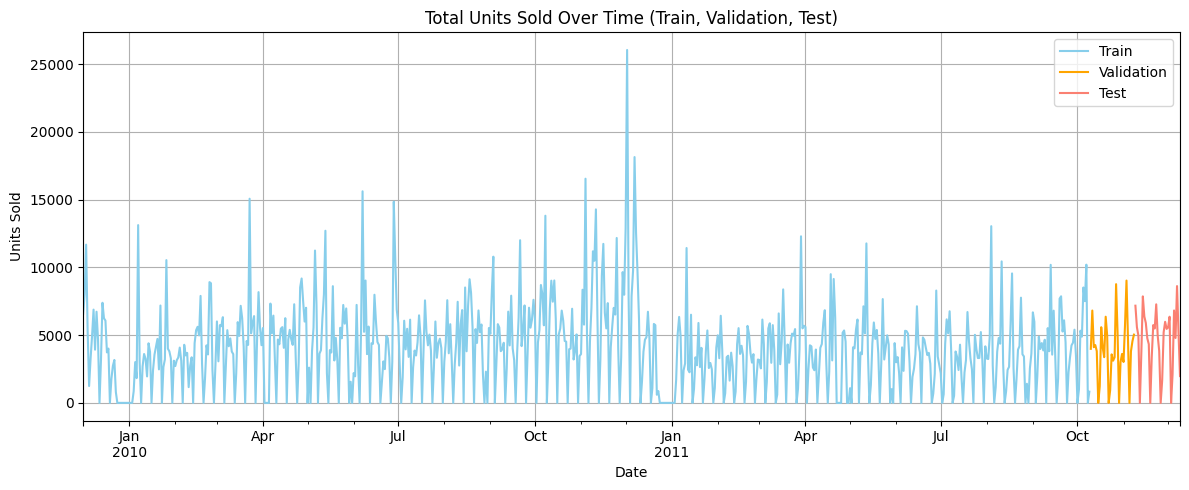

In [63]:
total_train_units_sold = train_df.groupby('Date')['UnitsSold'].sum()
total_val_units_sold = val_df.groupby('Date')['UnitsSold'].sum()
total_test_units_sold = test_df.groupby('Date')['UnitsSold'].sum()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

total_train_units_sold.sort_index().plot(ax=ax, label="Train", color="skyblue")
total_val_units_sold.sort_index().plot(ax=ax, label="Validation", color="orange")
total_test_units_sold.sort_index().plot(ax=ax, label="Test", color="salmon")

ax.set_title("Total Units Sold Over Time (Train, Validation, Test)")
ax.set_xlabel("Date")
ax.set_ylabel("Units Sold")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## Explore the best hyper-parameters

In [95]:
base_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="TimeIdx",
    target="UnitsSold",
    group_ids=["Description"],
    max_encoder_length=30,
    min_prediction_length=7,
    max_prediction_length=7,
    static_categoricals=["Description"],
    static_reals=[],
    time_varying_known_categoricals=[
        'IsWeekend',
        'IsHoliday',
        'DayOfWeek',
        'Month',
        'Quarter',
    ],
    time_varying_known_reals=[
        'AvgPricePerUnitPounds',
        'CCI',
        'CPI',
        'InterestRate',
        'Unemployment',
    ],
    time_varying_unknown_reals=[
        'UnitsSold',
        'DayBeforeUnitsSold',
        'WeekBeforeUnitsSold',
        'Rolling3DayMeanUnitsSold',
        'Rolling7DayMeanUnitsSold',
        'DayBeforeUnitsSold_x_IsWeekend',
        'DayBeforeUnitsSold_x_IsHoliday',
        'WeekBeforeUnitsSold_x_IsWeekend',
        'WeekBeforeUnitsSold_x_IsHoliday',
        'Rolling3DayMeanUnitsSold_x_IsWeekend',
        'Rolling3DayMeanUnitsSold_x_IsHoliday',
        'Rolling7DayMeanUnitsSold_x_IsWeekend',
        'Rolling7DayMeanUnitsSold_x_IsHoliday',
    ],
    # Known bug: https://github.com/sktime/pytorch-forecasting/issues/1208
    target_normalizer=TorchNormalizer(method="identity", center=False),
    add_relative_time_idx=True,
    allow_missing_timesteps=False,
)

val_and_test_dataset = TimeSeriesDataSet.from_dataset(
    base_dataset,
    val_and_test_df,
    predict=True,
    stop_randomization=True)

In [96]:
train_dataloader = base_dataset.to_dataloader(train=True, batch_size=64)
val_and_test_dataloader = val_and_test_dataset.to_dataloader(train=False, batch_size=64)

In [100]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs", name="tft_nb_optimization")

study = optimize_hyperparameters(
    train_dataloaders=train_dataloader,
    val_dataloaders=val_and_test_dataloader,
    model_path="optuna_nb_model",
    n_trials=50,
    max_epochs=30,
    loss=NegativeBinomialDistributionLoss(),
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(1e-5, 1e-2),
    dropout_range=(0.0, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
    trainer_kwargs=dict(
        accelerator="cpu",
        callbacks=[early_stop, lr_logger],
        logger=logger,
        limit_train_batches=30,  # remove for full training
    ),
    verbose=True,
)

print("Best parameters:", study.best_trial.params)

[I 2025-05-08 22:32:41,992] A new study created in memory with name: no-name-6232f75a-dd0a-4aeb-8c4a-55f86dc049e8
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=30` reached.
[I 2025-05-08 22:34:26,730] Trial 0 finished with value: 3.585686683654785 and parameters: {'gradient_clip_val': 0.08614969724960748, 'hidden_size': 20, 'dropout': 0.22163749376451955, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.008371618696475694}. Best is trial 0 with value: 3.585686683654785.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[I 2025-05-08 22:34:30,081] Trial 1 finished with value: 13.266791343688965 and parameters: {'gradient_clip_val': 0.038509995714212236, 'hidden_s

Best parameters: {'gradient_clip_val': 0.08614969724960748, 'hidden_size': 20, 'dropout': 0.22163749376451955, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.008371618696475694}


In [101]:
print("Best parameters:", study.best_trial.params)
print("Best loss:", study.best_value)

Best parameters: {'gradient_clip_val': 0.08614969724960748, 'hidden_size': 20, 'dropout': 0.22163749376451955, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.008371618696475694}
Best loss: 3.585686683654785


## Train the model

In [103]:
train_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="TimeIdx",
    target="UnitsSold",
    group_ids=["Description"],
    max_encoder_length=30,
    min_prediction_length=7,
    max_prediction_length=7,
    static_categoricals=["Description"],
    static_reals=[],
    time_varying_known_categoricals=[
        'IsWeekend',
        'IsHoliday',
        'DayOfWeek',
        'Month',
        'Quarter',
    ],
    time_varying_known_reals=[
        'AvgPricePerUnitPounds',
        'CCI',
        'CPI',
        'InterestRate',
        'Unemployment',
    ],
    time_varying_unknown_reals=[
        'UnitsSold',
        'DayBeforeUnitsSold',
        'WeekBeforeUnitsSold',
        'Rolling3DayMeanUnitsSold',
        'Rolling7DayMeanUnitsSold',
        'DayBeforeUnitsSold_x_IsWeekend',
        'DayBeforeUnitsSold_x_IsHoliday',
        'WeekBeforeUnitsSold_x_IsWeekend',
        'WeekBeforeUnitsSold_x_IsHoliday',
        'Rolling3DayMeanUnitsSold_x_IsWeekend',
        'Rolling3DayMeanUnitsSold_x_IsHoliday',
        'Rolling7DayMeanUnitsSold_x_IsWeekend',
        'Rolling7DayMeanUnitsSold_x_IsHoliday',
    ],
    # Known bug: https://github.com/sktime/pytorch-forecasting/issues/1208
    target_normalizer=TorchNormalizer(method="identity", center=False),
    add_relative_time_idx=True,
    allow_missing_timesteps=False,
)

val_and_test_dataset = TimeSeriesDataSet.from_dataset(
    base_dataset,
    val_and_test_df,
    predict=True,
    stop_randomization=True)

In [104]:
train_dataloader = base_dataset.to_dataloader(train=True, batch_size=64)
val_and_test_dataloader = val_and_test_dataset.to_dataloader(train=False, batch_size=64)

In [105]:
parameters = {
    'gradient_clip_val': 0.08614969724960748,
    'hidden_size': 20,
    'dropout': 0.22163749376451955,
    'hidden_continuous_size': 14,
    'attention_head_size': 4,
    'learning_rate': 0.008371618696475694
}

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=parameters['learning_rate'],
    hidden_size=parameters['hidden_size'],
    hidden_continuous_size=parameters['hidden_continuous_size'],
    attention_head_size=parameters['attention_head_size'],
    dropout=parameters['dropout'],
    loss=NegativeBinomialDistributionLoss(),
    log_interval=10,
    optimizer='ranger',
    reduce_on_plateau_patience=4,
)

In [ ]:
early_stop = EarlyStopping(monitor="train_loss_epoch", patience=10)
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs", name="tft_final")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",           # or "val_loss" if you use validation
    mode="min",                           # minimize the loss
    save_top_k=3,                         # only keep the best model
    save_last=True,                       # (optional) save last model too
    filename="best-tft-{epoch:02d}-{train_loss_epoch:.4f}",  # naming pattern
    dirpath="checkpoints/"                # where to save
)

trainer = Trainer(
    gradient_clip_val=parameters['gradient_clip_val'],
    accelerator="cpu",  # or "gpu" if available
    callbacks=[early_stop, lr_logger, checkpoint_callback],
    logger=logger,
)

trainer.fit(tft, train_dataloader, val_and_test_dataloader)

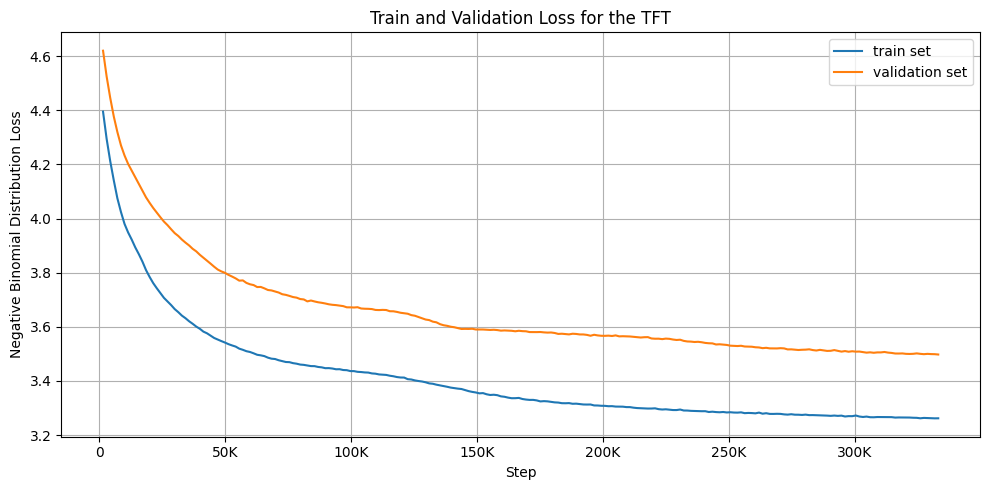

In [34]:
train_loss = pd.read_csv('training_loss.csv')
validation_loss = pd.read_csv('validation_loss.csv')

fig, ax = plt.subplots(figsize=(10,5))

train_loss.set_index('Step')['Value'].sort_index().plot(ax=ax, label='train set')
validation_loss.set_index('Step')['Value'].sort_index().plot(ax=ax, label='validation set')

ax.set_title('Train and Validation Loss for the TFT')
ax.set_xlabel('Step')
ax.set_ylabel('Negative Binomial Distribution Loss')
ax.legend()
ax.grid(True)
make_axes_human_readable(ax, axis='x')

plt.tight_layout()
plt.show()

In [29]:
train_loss

,Wall time,Step,Value
0,1.746762e+09,1423,4.395356
1,1.746763e+09,2847,4.295119
2,1.746763e+09,4271,4.212667
3,1.746763e+09,5695,4.141313
4,1.746764e+09,7119,4.075080
...,...,...,...
229,1.746828e+09,327519,3.263213
230,1.746828e+09,328943,3.262640
231,1.746829e+09,330367,3.261906
232,1.746829e+09,331791,3.261634


## Evaluate the model

In [26]:
checkpoint_path = './checkpoints/best-tft-epoch=232-train_loss_epoch=3.2616.ckpt'  # Add value to load from a specific directory
if not checkpoint_path:
    checkpoint_path = checkpoint_callback.best_model_path

best_model = TemporalFusionTransformer.load_from_checkpoint(
    checkpoint_path
)

In [21]:
summary = summarize(best_model, max_depth=2)
print(summary)

   | Name                                            | Type                             | Params | Mode 
--------------------------------------------------------------------------------------------------------------
0  | loss                                            | NegativeBinomialDistributionLoss | 0      | train
1  | logging_metrics                                 | ModuleList                       | 0      | train
2  | logging_metrics.0                               | SMAPE                            | 0      | train
3  | logging_metrics.1                               | MAE                              | 0      | train
4  | logging_metrics.2                               | RMSE                             | 0      | train
5  | logging_metrics.3                               | MAPE                             | 0      | train
6  | input_embeddings                                | MultiEmbedding                   | 3.0 K  | train
7  | input_embeddings.embeddings                 

In [168]:
def safe_round(raw_pred):
    """
    Safely rounds a prediction value to the nearest integer.

    This function ensures that any non-finite values (e.g., NaN, inf, -inf) 
    are replaced with a large constant (1e10) to avoid runtime errors or 
    invalid values during evaluation or export.

    Parameters
    ----------
    raw_pred : float
        The raw prediction value to round.

    Returns
    -------
    int or float
        A finite, rounded prediction. If the input is non-finite, returns 1e10.
    """
    if not np.isfinite(raw_pred):  # catches NaN, inf, -inf
        return 1e10
    else:
        return int(np.rint(raw_pred))

def get_predictions(model, context_df):
    """
    Generates multi-step forecasts for the last N days of each time series in the given context,
    using a trained Temporal Fusion Transformer (TFT) model.

    This function:
    - Constructs a prediction dataset from the provided historical context
    - Uses the trained model to forecast the next N time steps (decoder length) for each series
    - Extracts the predicted values, group identifiers, and time indices
    - Rounds predictions safely and reshapes them into long format for evaluation or analysis
    - Computes a forecast offset (1-based index) for each prediction step within each series

    Parameters
    ----------
    model : TemporalFusionTransformer
        A trained PyTorch Forecasting Temporal Fusion Transformer model.
    
    context_df : pandas.DataFrame
        A data frame containing the full context for forecasting, including all features 
        used during training (e.g., lags, known reals, categoricals). 
        Must include columns like 'TimeIdx' and 'Description'.

    Returns
    -------
    pandas.DataFrame
        A long-format DataFrame with columns:
        - 'Description': product name
        - 'TimeIdx': time index of the forecast
        - 'Prediction': rounded forecasted value
        - 'ForecastOffset': integer offset (starting from 1) for each forecast step
        
        Each row corresponds to a forecasted point. There will be one forecast per decoder step,
        per product.

    Notes
    -----
    - This function forecasts only the final N time steps for each series in the input,
      where N is the decoder length set during training (i.e., `max_prediction_length`).
    - Assumes all series have sufficient history to support the required encoder + decoder length.
    - All forecasts are post-processed with `safe_round()` to ensure numerical stability.
    - The 'ForecastOffset' column indicates the relative position (1 = first day ahead)
      within the decoder prediction window.
    """
    dataset_params = model.dataset_parameters
    
    predict_dataset = TimeSeriesDataSet.from_parameters(
        dataset_params,
        context_df,
        predict=True,
        stop_randomization=True
    )
    
    # Create the DataLoader
    pred_loader = predict_dataset.to_dataloader(train=False, batch_size=1)
    
    # Generate predictions with additional outputs
    raw_output = best_model.predict(
        pred_loader,
        return_x=True,
        return_y=True,
        return_index=True,
        trainer_kwargs={"accelerator": "cpu"}
    )

    pred_time_idxs = (
        raw_output.x['decoder_time_idx']
        .cpu()
        # Take the TimeIdx for the first product (they should all be the same)
        .numpy()[0]
        .flatten())
    
    pred_group_ids = (
        raw_output
        .x['groups']
        .cpu()
        .numpy()
        .flatten())
    
    preds = raw_output.output.cpu().numpy()

    product_description_to_id_map = (
        predict_dataset.categorical_encoders["Description"].classes_)
    
    id_to_preduct_description_map = {
        value: key
        for key, value in product_description_to_id_map.items()}

    product_names = [id_to_preduct_description_map[i] for i in pred_group_ids]

    pred_df = pd.DataFrame(
        columns=pred_time_idxs,
        index=product_names,
        data=preds
    )

    pred_df.index.name = "Description"

    pred_df = pred_df.applymap(safe_round)

    pred_df = pred_df.reset_index().melt(
        id_vars="Description",
        var_name="TimeIdx",
        value_name="Prediction"
    )

    pred_df.insert(
        2,
        'ForecastOffset',
        pred_df
        .sort_values(['Description', 'TimeIdx'])
        .groupby('Description')
        .cumcount() + 1)

    pred_df = pred_df.sort_values(by=['Description', 'TimeIdx'])

    return pred_df

In [227]:
def forecast_all_products_matrix(model, full_context_df, evaluation_start_date):
    """
    Generates a rolling forecast matrix for all products using a trained Temporal Fusion Transformer (TFT) model.

    For each day starting from `evaluation_start_date`, this function:
    - Constructs a context window ending on (current_date + forecast_horizon - 1)
    - Runs the TFT model to forecast the last N=7 days of the context window
    - Maps each forecast to its actual calendar date
    - Inserts the predictions into a wide-format forecast matrix, where each column represents a forecast horizon
      (1-day ahead, 2-day ahead, ..., 7-day ahead)
    - Aligns the predictions with the actual observed values of `UnitsSold`

    Parameters
    ----------
    model : TemporalFusionTransformer
        A trained PyTorch Forecasting Temporal Fusion Transformer model capable of forecasting across all products.
    
    full_context_df : pandas.DataFrame
        Full historical and future feature data including:
        - 'Description' (product identifier)
        - 'Date' (calendar date)
        - 'TimeIdx' (integer time index used by TFT)
        - 'UnitsSold' (target variable)
        and all other known/unknown features used for training and prediction.

    evaluation_start_date : pd.Timestamp
        The first date from which to begin rolling forecast generation.
        Each prediction window includes up to 7 days following the current date.

    Returns
    -------
    pandas.DataFrame
        A wide-format forecast matrix with one row per (Product, Date), and columns:
        - '1' to '7': predictions made 1 to 7 days ahead of the forecast origin
        - 'observed': the true value of `UnitsSold` for that (Product, Date)
        - 'Product': the product description
        - 'Date': the calendar date of the forecast target

    Notes
    -----
    - Only dates on or after `evaluation_start_date` are included in the output.
    - For each (Product, Date), multiple predictions may be filled across horizons
      if that date appears in multiple rolling forecast windows.
    - Missing predictions remain as NaN when a product/date/horizon combination was not covered by any forecast window.
    """
    forecast_horizon = 7

    # Ensure Dates are sorted and unique
    last_date = full_context_df['Date'].max()
    descriptions = full_context_df['Description'].unique()

    # Base forecast matrix with observed values
    forecast_matrix = full_context_df[['Date', 'Description', 'UnitsSold']].copy()
    forecast_matrix = forecast_matrix[forecast_matrix['Date'] >= evaluation_start_date]
    forecast_matrix = forecast_matrix.rename(columns={
        'Description': 'Product',
        'UnitsSold': 'observed'
    })

    # Add empty horizon columns (1 to 7)
    forecast_horizons = list(range(1, forecast_horizon + 1))
    forecast_matrix[forecast_horizons] = np.nan
    forecast_matrix = forecast_matrix.sort_values(['Product', 'Date'])

    # TimeIdx-to-Date lookup
    timeidx_lookup = full_context_df[['Description', 'TimeIdx', 'Date']].drop_duplicates()

    for current_date in tqdm(
        pd.date_range(evaluation_start_date, last_date - timedelta(days=forecast_horizon - 1)),
        desc='Rolling TFT Forecast'
    ):
        window_end = min(current_date + timedelta(days=forecast_horizon - 1), last_date)

        # Context used for generating prediction
        context_df = full_context_df[full_context_df['Date'] <= window_end].copy()

        try:
            pred_df = get_predictions(model, context_df)
        except Exception as e:
            print(f'Skipping {current_date.date()} due to error: {e}')
            continue

        # Merge predicted TimeIdxs back to Dates
        merged_with_dates = pred_df.merge(
            timeidx_lookup,
            how='left',
            on=['Description', 'TimeIdx']
        ).rename(columns={'Description': 'Product'})

        # Fill forecast_matrix with each prediction
        for _, row in merged_with_dates.iterrows():
            try:
                forecast_matrix.loc[
                    (forecast_matrix['Product'] == row['Product']) &
                    (forecast_matrix['Date'] == row['Date']),
                    row['ForecastOffset']
                ] = row['Prediction']
            except Exception as e:
                print(f'Failed to assign prediction at {row['Product']} - {row['Date']}: {e}')
                continue

    # Reorder columns
    forecast_matrix = forecast_matrix[forecast_horizons + ['observed', 'Product', 'Date']]

    return forecast_matrix

In [228]:
last_date = tft_df["Date"].max()
evaluation_start_date = last_date - timedelta(days=60)

# Run the forecast function
forecast_matrix = forecast_all_products_matrix(
    model=best_model,
    full_context_df=tft_df,
    evaluation_start_date=evaluation_start_date
)

Rolling TFT Forecast: 100%|██████████| 55/55 [03:03<00:00,  3.34s/it]


In [239]:
def smape(y_true, y_pred):
    """
    Compute symmetric Mean Absolute Percentage Error (sMAPE) with special case:
    If both y_true and y_pred are 0, sMAPE is defined as 0.

    Args:
        y_true: Array-like of actual values.
        y_pred: Array-like of predicted values.

    Returns:
        sMAPE as a percentage.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)

    # Special handling: if both y and y_hat are 0, define sMAPE = 0
    smape_values = np.zeros_like(numerator, dtype=float)
    mask = denominator != 0
    smape_values[mask] = numerator[mask] / denominator[mask]

    return 100 * np.mean(smape_values)

In [240]:
def compute_smape_matrix_by_product(forecast_df, forecast_len=7):
    """
    Compute sMAPE for each product and each forecast horizon, returning wide format.

    Args:
        forecast_df: DataFrame from forecast_all_products_matrix_ols
        forecast_len: Number of forecast days ahead (horizons)

    Returns:
        DataFrame with one row per product, and columns 'Horizon_1' to 'Horizon_7'
    """
    result_rows = []

    for product in forecast_df["Product"].unique():
        df_product = forecast_df[forecast_df["Product"] == product]
        smape_row = {"Product": product}
        for h in range(1, forecast_len + 1):
            subset = df_product[[h, "observed"]].dropna()
            smape_score = smape(subset["observed"], subset[h])
            smape_row[f"Horizon_{h}"] = smape_score
        result_rows.append(smape_row)

    return pd.DataFrame(result_rows)

In [242]:
smape_df = compute_smape_matrix_by_product(forecast_matrix)
smape_df

,Product,Horizon_1,Horizon_2,Horizon_3,Horizon_4,Horizon_5,Horizon_6,Horizon_7
0,12 pencils small tube red spotty,35.682685,36.218953,35.709638,35.754027,35.789442,34.530212,35.461718
1,12 pencils tall tube posy,39.894321,40.767516,41.294970,41.872743,42.300481,41.423255,42.558861
2,12 pencils tall tube woodland,28.512765,30.831361,30.781346,32.359852,31.398142,31.205887,32.967378
3,6 ribbons rustic charm,29.555111,30.257276,30.767021,30.337551,31.016964,30.715729,31.813945
4,60 teatime fairy cake cases,46.117390,46.298388,45.004456,46.738115,46.593518,45.627932,47.581235
...,...,...,...,...,...,...,...,...
137,wooden rounders garden set,37.993629,37.974552,37.405293,39.264634,39.443112,36.138250,39.796305
138,wooden school colouring set,37.161229,38.295572,38.873726,38.365813,38.494587,39.293456,40.464843
139,woodland charlotte bag,36.690116,36.519382,37.517858,36.279602,37.233445,37.280314,37.073044
140,world war 2 gliders asstd designs,38.037367,37.176925,37.406308,38.062775,38.767702,39.616097,39.924218


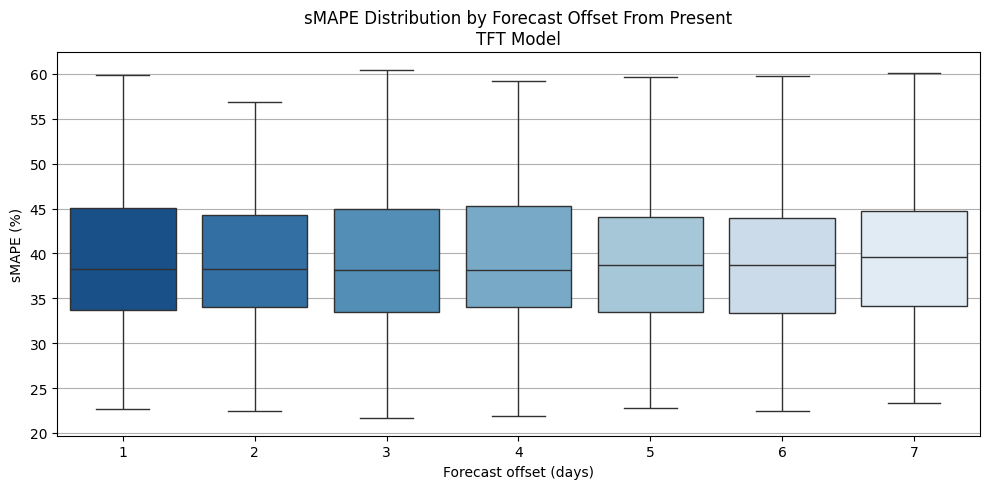

In [35]:
# Convert wide-format sMAPE matrix to long format
smape_long_df = smape_df.melt(id_vars="Product", 
                               var_name="Horizon", 
                               value_name="sMAPE")

# Extract numeric horizon and sort
smape_long_df["Horizon"] = smape_long_df["Horizon"].str.replace("Horizon_", "").astype(int)

# Create a shades-of-blue palette from dark to light (reversed Blues)
palette = sns.color_palette("Blues", n_colors=7)[::-1]  # darkest first

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=smape_long_df, x="Horizon", y="sMAPE", palette=palette, showfliers=False, ax=ax)

ax.set_title("sMAPE Distribution by Forecast Offset From Present\nTFT Model")
ax.set_xlabel("Forecast offset (days)")
ax.set_ylabel("sMAPE (%)")
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [244]:
smape_long_df.groupby('Horizon').describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90]).round(2)

sMAPE                                                              
         count   mean   std    min    10%    25%    50%    75%    90%    max
Horizon                                                                     
1        142.0  39.84  9.83  22.63  29.01  33.71  38.28  45.02  51.16  81.29
2        142.0  39.90  9.72  22.42  29.79  34.07  38.23  44.32  50.72  81.39
3        142.0  39.76  9.72  21.63  29.88  33.45  38.12  44.91  50.92  80.56
4        142.0  39.82  9.68  21.93  30.20  34.03  38.19  45.28  50.71  79.94
5        142.0  39.83  9.53  22.73  30.31  33.44  38.75  44.09  50.78  80.40
6        142.0  39.60  9.51  22.49  30.28  33.35  38.75  43.96  50.18  80.72
7        142.0  40.49  9.47  23.31  30.63  34.11  39.63  44.76  50.89  84.41

In [246]:
# Compute symmetric absolute percentage error (sAPE) matrix for each day and product
sape_matrix_df = forecast_matrix.copy()
for h in range(1, 8):
    pred = sape_matrix_df[h]
    obs = sape_matrix_df["observed"]
    denominator = np.abs(obs) + np.abs(pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        sape = np.where((obs == 0) & (pred == 0), 0, np.abs(pred - obs) / denominator)
    sape_matrix_df[h] = sape * 100  # Convert to percentage

# Calculate mean sAPE per day of week and product for 1-day horizon
sape_df = sape_matrix_df[["Date", "Product", 1]].copy()
sape_df["DayOfWeek"] = sape_df["Date"].dt.day_name()
smape_by_dayofweek = sape_df.groupby(["DayOfWeek", "Product"])[1].mean().reset_index()
smape_by_dayofweek = smape_by_dayofweek.rename(columns={1: "sMAPE"})
smape_by_dayofweek

,DayOfWeek,Product,sMAPE
0,Friday,12 pencils small tube red spotty,65.875030
1,Friday,12 pencils tall tube posy,47.816122
2,Friday,12 pencils tall tube woodland,31.892819
3,Friday,6 ribbons rustic charm,56.725869
4,Friday,60 teatime fairy cake cases,67.569398
...,...,...,...
989,Wednesday,wooden rounders garden set,22.648810
990,Wednesday,wooden school colouring set,39.218406
991,Wednesday,woodland charlotte bag,53.586552
992,Wednesday,world war 2 gliders asstd designs,47.091170


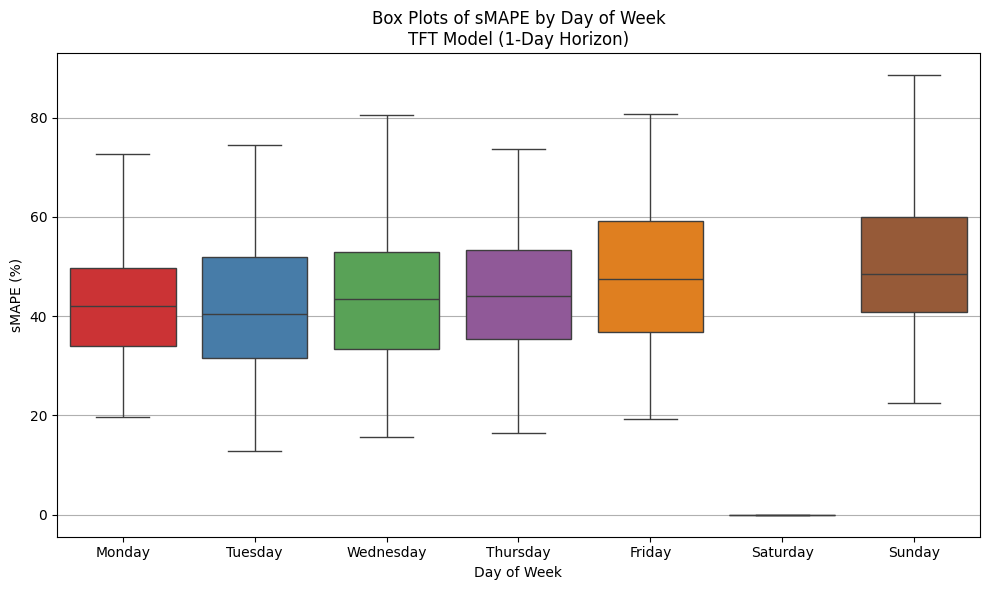

In [248]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Set desired order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot
sns.boxplot(
    x='DayOfWeek',
    y='sMAPE',
    data=smape_by_dayofweek,
    order=day_order,
    showfliers=False,
    palette='Set1'
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('sMAPE (%)')
plt.title('Box Plots of sMAPE by Day of Week\nTFT Model (1-Day Horizon)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [249]:
smape_by_dayofweek.groupby('DayOfWeek').describe().round(2)

sMAPE                                                 
           count   mean    std    min    25%    50%    75%    max
DayOfWeek                                                        
Friday     142.0  48.47  15.74  19.27  36.87  47.59  59.27  100.0
Monday     142.0  43.79  14.25  19.70  34.06  42.08  49.76  100.0
Saturday   142.0   5.02  16.78   0.00   0.00   0.00   0.00   87.5
Sunday     142.0  50.46  14.42  22.49  40.83  48.41  60.05  100.0
Thursday   142.0  45.63  14.44  16.47  35.49  44.11  53.35  100.0
Tuesday    142.0  42.85  15.96  12.89  31.67  40.36  51.87  100.0
Wednesday  142.0  44.02  15.48  15.75  33.43  43.49  52.86  100.0

In [258]:
h1_smape = smape_df[['Product', 'Horizon_1']].set_index('Product')['Horizon_1']
q1 = h1_smape.quantile(0.10)
q3 = h1_smape.quantile(0.90)

q1_products = h1_smape[lambda x: x <= q1]
mid_products = h1_smape[lambda x: (q1 < x) & (x < q3)]
q3_products = h1_smape[lambda x: x >= q3]

q1_products_sample = q1_products.sort_values().head(4)
mid_products_sample = mid_products.sample(n=4, replace=False, random_state=42).sort_values()
q3_products_sample = q3_products.sample(n=4, replace=False, random_state=42).sort_values()

In [259]:
combined_sample = pd.concat([q1_products_sample[0:2], mid_products_sample[0:1], q3_products_sample[0:1]])
combined_sample

Product
lunch bag black skull             22.630586
natural slate heart chalkboard    23.302958
love building block word          32.439482
toilet metal sign                 51.310639
Name: Horizon_1, dtype: float64

In [260]:
def plot_forecast_grid(products, train_df, val_df, forecast_df, smape_series, title, ncols=4):
    """
    Plot a grid of forecast panels for given products showing the 60 days of training data,
    all of test data, and model forecasts.

    Args:
        products: list of product names (str)
        train_df: DataFrame with training data (columns: Description, Date, UnitsSold)
        val_df: DataFrame with validation+test data (columns: Description, Date, UnitsSold)
        forecast_df: DataFrame with predictions (columns: Product, Date, 1 for forecast, observed)
        smape_series: Series with sMAPE values indexed by Product
        title: Title of the full figure
        ncols: number of columns in the plot grid
    """
    n = len(products)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows))
    axs = axs.flatten()

    fig.suptitle(title, fontweight='bold', fontsize=14)

    for ax, product in zip(axs, products):
        mape = round(smape_series.loc[product], 2)

        product_train = train_df.query('Description == @product').sort_values("Date")
        product_val = val_df.query('Description == @product').sort_values("Date")
        product_forecast = forecast_df.query('Product == @product').sort_values("Date")

        if not product_train.empty:
            last_train_date = product_train["Date"].max()
            cutoff = last_train_date - timedelta(days=60)
            train_series = product_train[product_train["Date"] > cutoff].set_index("Date")["UnitsSold"]
            train_series.plot(ax=ax, color='tab:blue', label='training')
        
        if not product_val.empty:
            val_series = product_val.set_index("Date")["UnitsSold"]
            val_series.plot(ax=ax, color='tab:grey', alpha=0.6, label='observed')
        
        if not product_forecast.empty:
            pred_series = product_forecast.set_index("Date")[1]
            pred_series = pred_series.clip(lower=0, upper=500)  # Adjust upper limit as needed
            pred_series.plot(ax=ax, color='tab:orange', alpha=0.6, label='predicted')

        ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=9)
        ax.set_xlabel('Date')
        ax.set_ylabel('Units sold')
        ax.grid(True)
        ax.legend()
        make_axes_human_readable(ax)

    for j in range(len(products), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

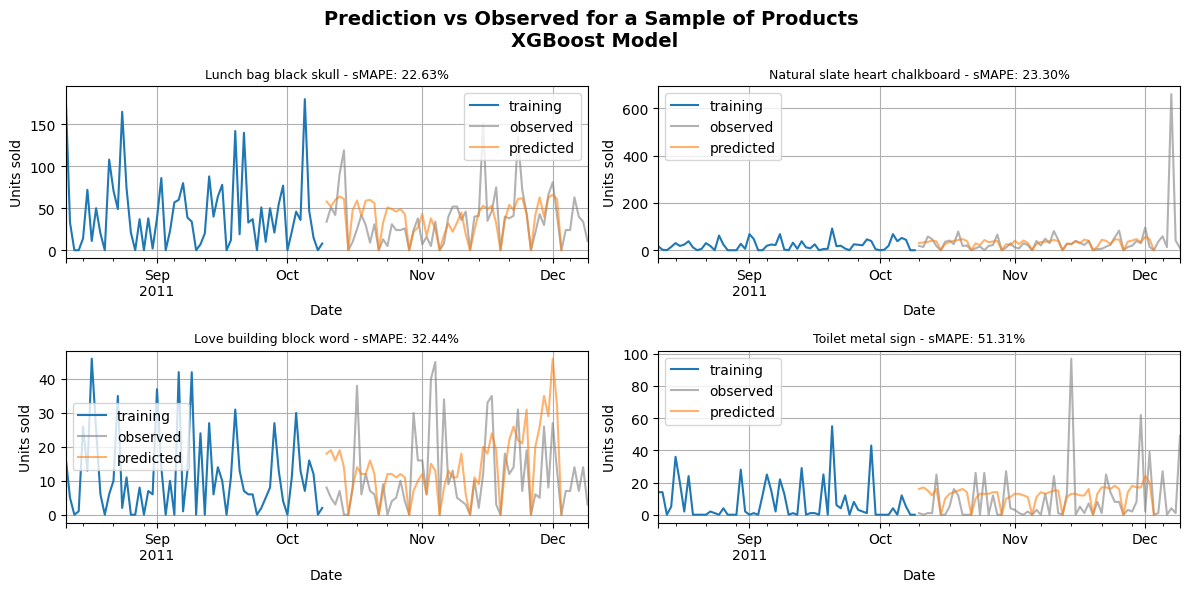

In [ ]:
plot_forecast_grid(
    products=combined_sample.index.tolist(),
    train_df=train_df,
    val_df=val_and_test_df,
    forecast_df=forecast_matrix,
    smape_series=h1_smape,
    title="Prediction vs Observed for a Sample of Products \nTFT Model",
    ncols=2
)

In [262]:
def plot_log_units_histogram(products, train_df, val_df, forecast_df, smape_series, title, ncols=2):
    """
    Plot a grid of histograms showing the distribution of log-transformed units sold
    for a set of products, using seaborn histplot with KDE.

    Args:
        products: list of product names (str)
        train_df: DataFrame with training data (columns: Description, Date, UnitsSold)
        val_df: DataFrame with validation/test data (columns: Description, Date, UnitsSold)
        forecast_df: DataFrame with predictions (columns: Product, Date, 1 for forecast, observed)
        smape_series: Series with sMAPE values indexed by Product
        title: Title of the full figure
        ncols: number of columns in the plot grid
    """
    n = len(products)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
    axs = axs.flatten()

    fig.suptitle(title, fontweight='bold', fontsize=14)

    for ax, product in zip(axs, products):
        mape = round(smape_series.loc[product], 2)

        # Get log-transformed data for units sold > 0
        train_series = train_df.query('Description == @product and UnitsSold > 0')["UnitsSold"].apply(np.log)
        val_series = val_df.query('Description == @product and UnitsSold > 0')["UnitsSold"].apply(np.log)
        pred_series = forecast_df.query('Product == @product')[1]
        pred_series = pred_series.apply(np.log1p)

        sns.histplot(train_series, kde=True, stat='percent', bins=15, color='tab:blue', label='training', ax=ax, element='step', fill=True)
        sns.histplot(val_series, kde=True, stat='percent', bins=15, color='tab:grey', label='observed', ax=ax, element='step', fill=True)
        sns.histplot(pred_series, kde=True, stat='percent', bins=15, color='tab:orange', label='predicted', ax=ax, element='step', fill=True)

        ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
        ax.set_xlabel('log1p(Units sold)')
        ax.set_ylabel('Frequency (%)')
        ax.grid(True)
        ax.legend()

    for j in range(len(products), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

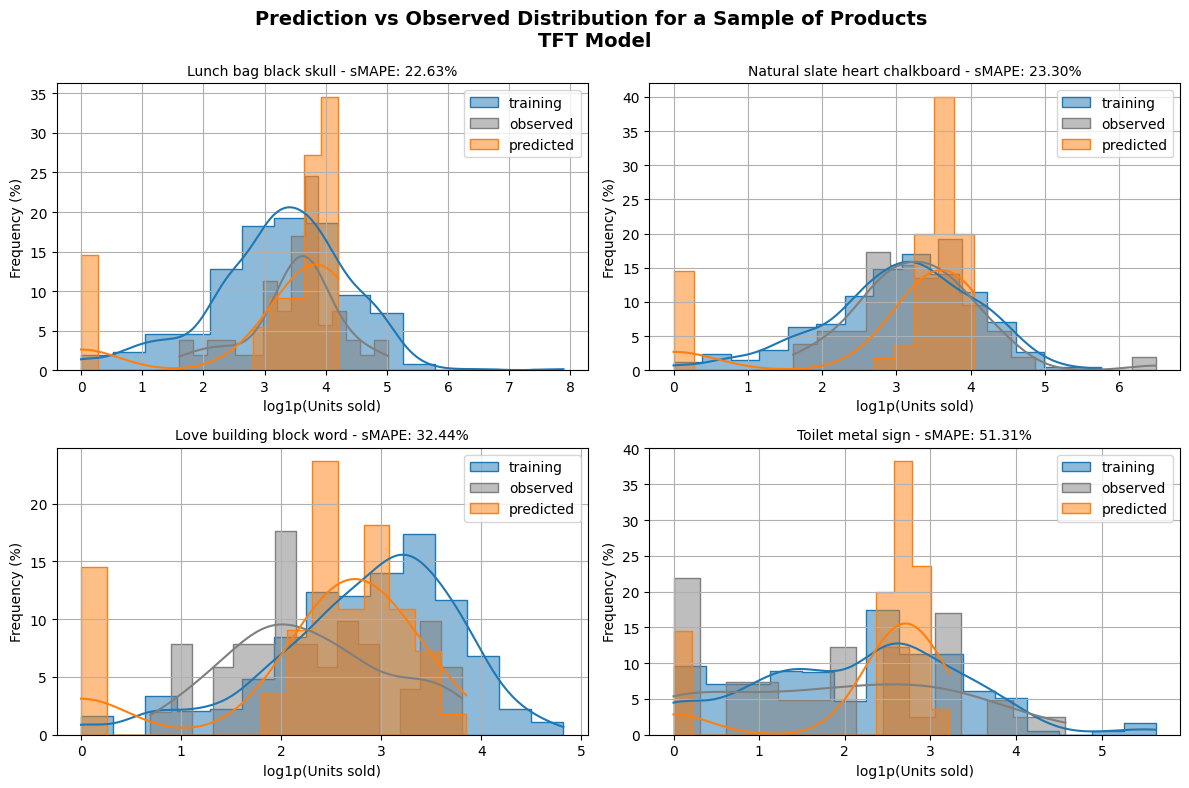

In [264]:
plot_log_units_histogram(
    products=combined_sample.index.tolist(),
    train_df=train_df,
    val_df=val_and_test_df,
    forecast_df=forecast_matrix,
    smape_series=h1_smape,
    title="Prediction vs Observed Distribution for a Sample of Products \nTFT Model",
    ncols=2
)

In [265]:
def plot_pred_vs_actual_scatter(products, forecast_df, smape_series, title, ncols=2):
    """
    Plot scatter plots comparing predicted vs. actual units sold for a list of products.
    Includes a y = x reference line.

    Args:
        products: list of product names (str)
        forecast_df: DataFrame with predictions (columns: Product, Date, 1 for forecast, observed)
        smape_series: Series with sMAPE values indexed by Product
        title: Title of the full figure
        ncols: number of columns in the plot grid
    """
    n = len(products)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
    axs = axs.flatten()

    fig.suptitle(title, fontweight='bold', fontsize=14)

    for ax, product in zip(axs, products):
        df = forecast_df.query("Product == @product")[["observed", 1]].dropna()
        df = df[df["observed"] >= 0]
        df = df[df[1] >= 0]

        mape = round(smape_series.loc[product], 2)

        ax.scatter(df["observed"], df[1], alpha=0.6, color='tab:orange', edgecolor='k', s=30, label='')
        min_val = min(df["observed"].min(), df[1].min())
        max_val = max(df["observed"].max(), df[1].max())
        ax.plot([min_val, max_val], [min_val, max_val], color='tab:blue', linestyle='--', label='observed = forecast')

        ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
        ax.set_xlabel('Observed Units Sold')
        ax.set_ylabel('Predicted Units Sold')
        ax.grid(True)
        ax.legend()

    for j in range(len(products), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

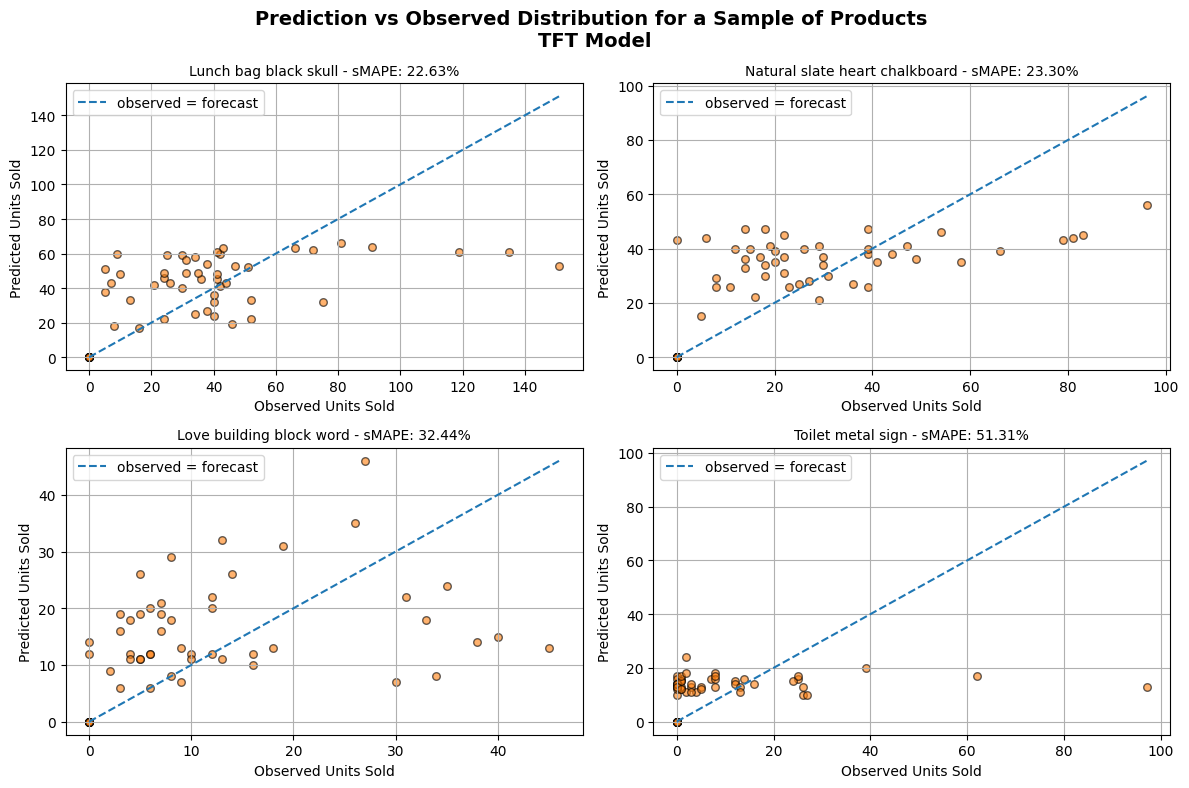

In [268]:
plot_pred_vs_actual_scatter(
    products=combined_sample.index.tolist(),
    forecast_df=forecast_matrix,
    smape_series=h1_smape,
    title="Prediction vs Observed Distribution for a Sample of Products \nTFT Model",
    ncols=2
)

In [269]:
def plot_residuals_vs_prediction_with_loess(products, forecast_df, smape_series, title, ncols=2):
    """
    Plot residuals (predicted - actual) against predicted values with a LOESS smoothing line.

    Args:
        products: list of product names (str)
        forecast_df: DataFrame with predictions (Product, Date, observed, 1)
        smape_series: Series with sMAPE values indexed by Product
        title: Title for the entire plot grid
        ncols: Number of columns in subplot grid
    """
    n = len(products)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3.5 * nrows))
    axs = axs.flatten()

    fig.suptitle(title, fontweight='bold', fontsize=14)

    for ax, product in zip(axs, products):
        df = forecast_df.query("Product == @product")[["observed", 1]].dropna()
        df = df[(df["observed"] >= 0) & (df[1] >= 0)]
        df["residual"] = df[1] - df["observed"]

        mape = round(smape_series.loc[product], 2)

        sns.scatterplot(x=df[1], y=df["residual"], ax=ax, color='tab:red', edgecolor='k', s=30, alpha=0.6, label='Residual')
        sns.regplot(x=df[1], y=df["residual"], ax=ax, scatter=False, color='black', lowess=True, label='LOESS')

        ax.axhline(0, linestyle='--', color='grey', linewidth=1)
        ax.set_title(f"{product.capitalize()} - sMAPE: {mape:.2f}%", fontsize=10)
        ax.set_xlabel("Predicted Units Sold")
        ax.set_ylabel("Residual (Pred - Actual)")
        ax.grid(True)
        ax.legend()

    for j in range(len(products), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

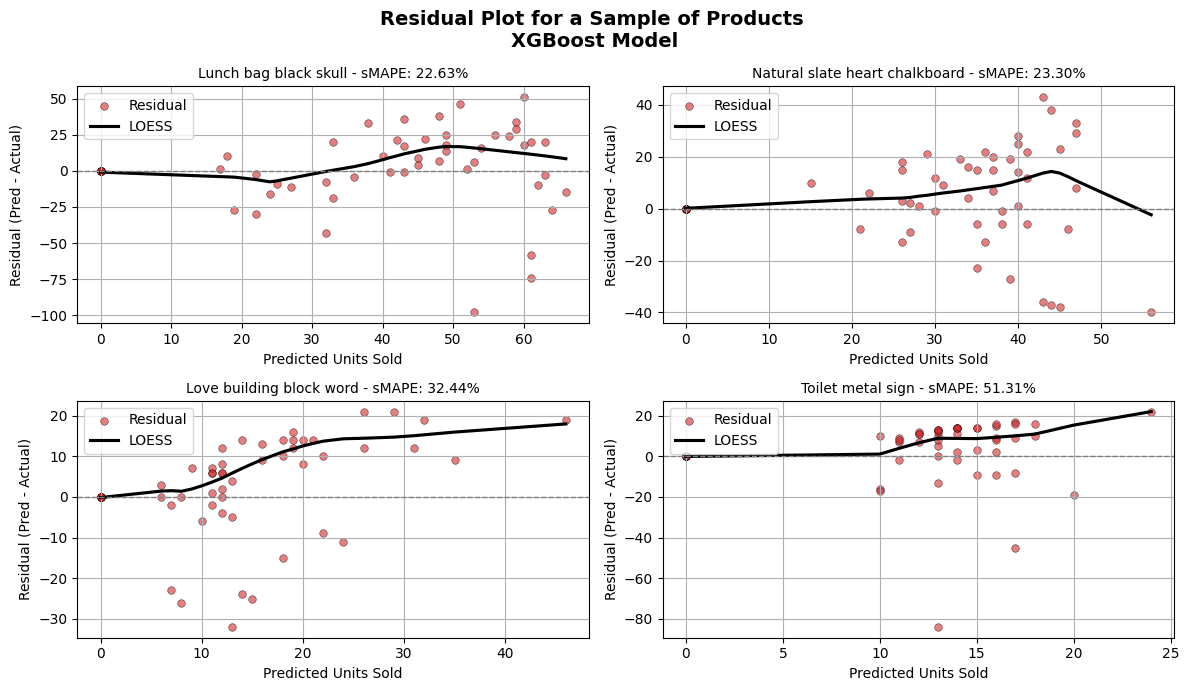

In [270]:
plot_residuals_vs_prediction_with_loess(
    products=combined_sample.index.tolist(),
    forecast_df=forecast_matrix,
    smape_series=h1_smape,
    title="Residual Plot for a Sample of Products \nXGBoost Model",
    ncols=2
)

In [271]:
def plot_product_horizon_smape_heatmap(smape_df_matrix, title="Product-Level sMAPE Heatmap by Horizon"):
    """
    Create a heatmap of sMAPE values by product and forecast horizon.

    Args:
        smape_df_matrix: DataFrame with one row per product, columns Horizon_1 ... Horizon_7
        title: Plot title
    """
    smape_matrix = smape_df_matrix.set_index("Product").copy()
    smape_matrix.columns = [col.replace("Horizon_", "Day ") for col in smape_matrix.columns]

    # Sort by average sMAPE across horizons
    smape_matrix["Average"] = smape_matrix.mean(axis=1)
    smape_matrix = smape_matrix.sort_values("Average", ascending=False).drop(columns="Average")

    plt.figure(figsize=(12, max(6, len(smape_matrix) * 0.25)))
    sns.heatmap(smape_matrix, annot=False, cmap="YlOrRd", linewidths=0.5, linecolor="grey", cbar_kws={'label': 'sMAPE (%)'})
    plt.title(title, fontweight="bold")
    plt.xlabel("Forecast Horizon")
    plt.ylabel("Product")
    plt.tight_layout()
    plt.show()

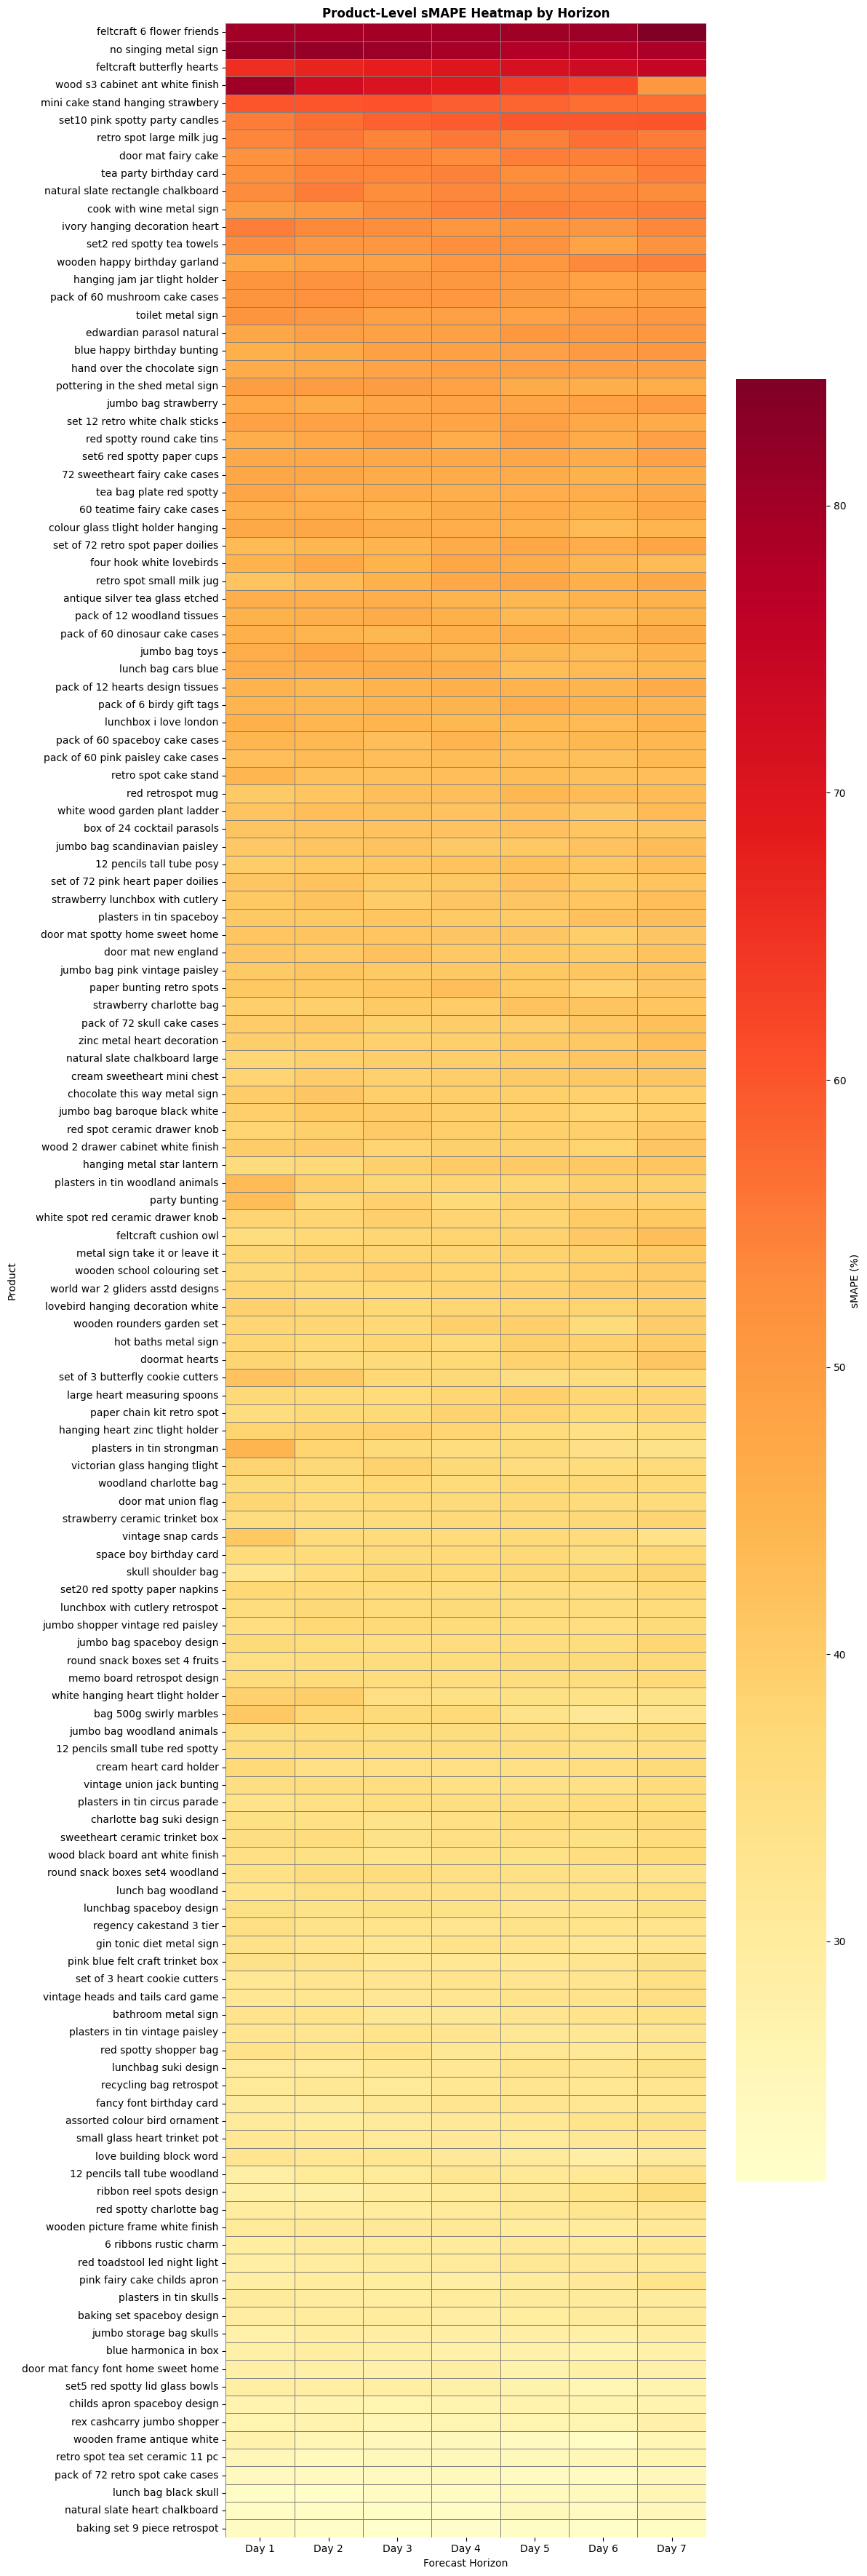

In [272]:
plot_product_horizon_smape_heatmap(smape_df)